# Cosine Simularity: An Exploration

This notebook is an exploration of calculating cosine simularity of average beer ratings as well as the vectorized text.

First, I import various libraries that I will use for querying and manipulating data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sqlalchemy import create_engine, text as sql
from sklearn.metrics.pairwise import cosine_similarity

# https://stackoverflow.com/a/29665452/2548452
from IPython.display import display, HTML

%matplotlib inline

In [2]:
pg_pass = os.environ['BEER_DB']
engine = create_engine(pg_pass)

Now I am going to run a query to generate a dataframe of all of the breweries within 10 miles of the Santa Monica GA campus  along with their respective beers that have text ratings. I will also get the average rating of various beers from these breweries.

This is just a cursory look at how similar ratings are for beers within my local area based on the style.

The general observation that I see is that beers in my local area tend to have very similar scores and it is only when I adjust the scores to the power of 3 that I can "see" any real difference in the cosine similarity of beer scores with the same style in my area.

Beers with darker squares than the rest of the heatmaps will have much higher or much lower scores relative to everything else.

In [3]:
near_ga_beers_query = """
SELECT ST_Distance(
    ST_GeomFromText('POINT(34.01080683333333 -118.4922238333333)', 4326), 
    ST_GeomFromText(ST_AsText(position), 4326)
) * 57.884 AS distance, 
breweries.name AS brewery_name,
beers.name AS beer_name,
AVG(reviews.review_overall) as overall,
AVG(reviews.review_appearance) as appearance,
AVG(reviews.review_aroma) as aroma,
AVG(reviews.review_taste) as taste,
AVG(reviews.review_palate) as palate,
styles.name AS style
FROM breweries
JOIN (
    beers JOIN styles 
    ON ( beers.style_id = styles.id)
    JOIN reviews
    ON ( beers.id = reviews.beer_id)
) ON breweries.id = beers.brewery_id 
WHERE ST_DWithin(
    ST_GeomFromText('POINT(34.01080683333333 -118.4922238333333)', 4326),
    ST_GeomFromText(ST_AsText(breweries.position), 4326), 10/57.884
)
AND reviews.review_overall IS NOT NULL
GROUP BY styles.name, breweries.position, breweries.name, beers.name
ORDER BY distance;
"""

In [4]:
results = pd.read_sql(near_ga_beers_query, con=engine)

In [5]:
results.dropna(inplace=True)

,overall,appearance,aroma,taste,palate
beer_name,,,,,
Collaboradler,4.000000,3.250000,3.500000,4.000000,4.000000
McAle's Hard Apple Ale Re,3.750000,3.750000,4.000000,3.500000,3.500000
McAle's Hard Apple Ale Gr,3.500000,3.750000,3.750000,3.250000,3.250000
Old Style Cooler by the L,3.166667,3.166667,3.083333,3.166667,3.250000
National Bohemian Beer Cr,2.954545,3.454545,3.181818,2.863636,2.931818


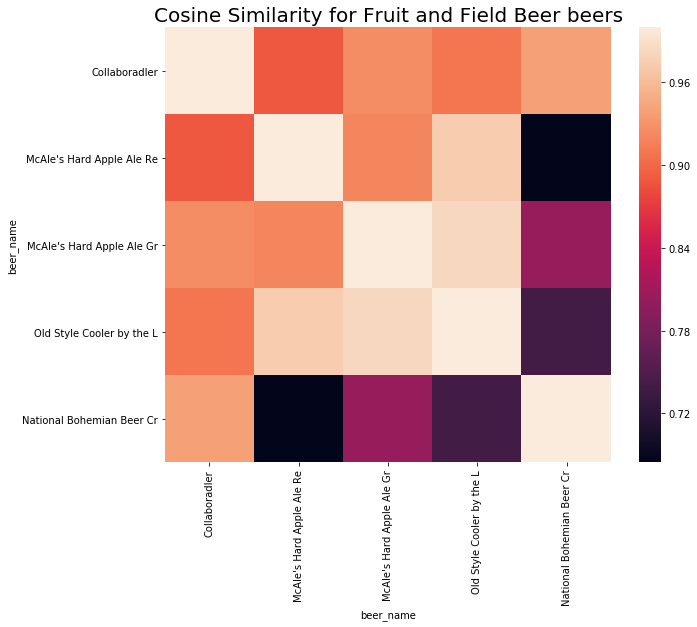

,overall,appearance,aroma,taste,palate
beer_name,,,,,
Country Club Malt Liquor,2.824324,2.864865,2.337838,2.621622,2.581081
Colt 45 High Gravity Lage,2.767857,3.232143,2.803571,2.821429,2.821429
Colt 45 Malt Liquor,2.666667,2.577236,2.170732,2.459350,2.575203
Silver Thunder,2.397727,2.909091,2.386364,2.590909,2.681818
Stack High Gravity Lager,1.884615,2.846154,2.307692,2.019231,2.057692
Colt 45,1.845200,2.000000,1.828125,1.875000,1.859375


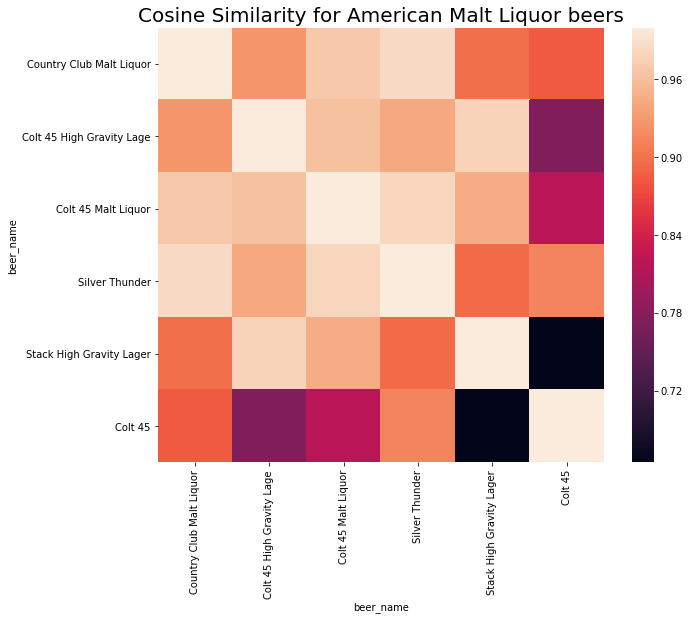

,overall,appearance,aroma,taste,palate
beer_name,,,,,
Dual Citizen DIPA,4.250000,4.277778,4.250000,4.250000,4.194444
Nuclear Power Plant,4.187500,4.156250,4.156250,4.125000,4.125000
Two 5 Left,4.176471,3.941176,4.264706,4.235294,3.911765
Surfin' Bird,4.150000,4.190000,4.190000,4.220000,4.160000
Wet Hop Citra-Mongous DIP,4.150000,4.150000,4.200000,4.300000,4.200000
Hop Tanker,4.130769,4.155172,4.206897,4.120690,4.137931
Hammerland DIPA,4.125000,3.656250,4.406250,4.281250,4.187500
Seis Del Segundo,4.125000,4.000000,4.125000,4.125000,4.000000
Knotty DIPA,4.092759,4.092105,4.105263,4.105263,4.057018


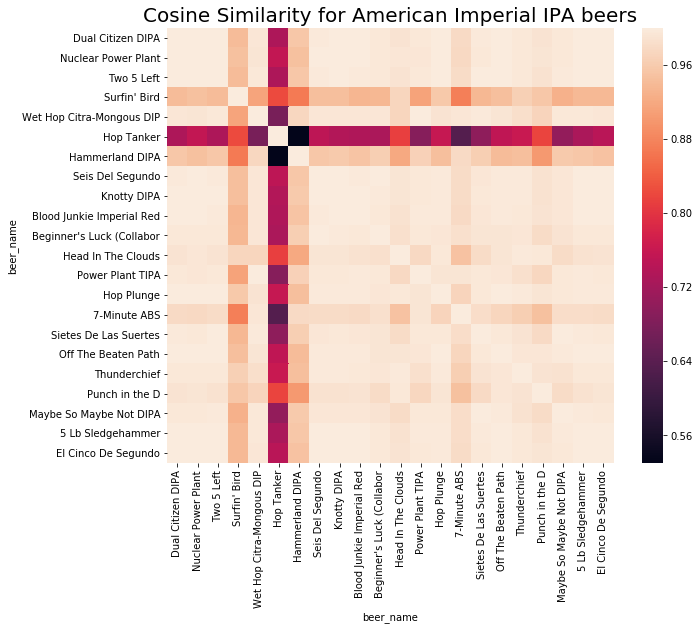

,overall,appearance,aroma,taste,palate
beer_name,,,,,
Lime Lager 009,3.750000,4.000000,3.750000,3.750000,4.000000
Stag,3.666667,3.166667,2.833333,3.263158,3.201754
Pabst Blue Ribbon (PBR),3.613777,2.901302,2.682659,3.102467,3.006511
National Bohemian Beer,3.577320,2.798969,2.644330,3.087629,3.092784
Olympia 95% Malt,3.558824,3.588235,3.058824,3.529412,3.441176
Pabst Genuine Draft,3.533333,2.933333,2.633333,2.866667,3.133333
National Bohemian Ice Bee,3.375000,3.187500,3.000000,3.187500,3.000000
Old Style,3.324713,2.864943,2.701149,2.977011,2.948276
Olympia Beer,3.293750,2.875000,2.562500,2.862500,2.843750


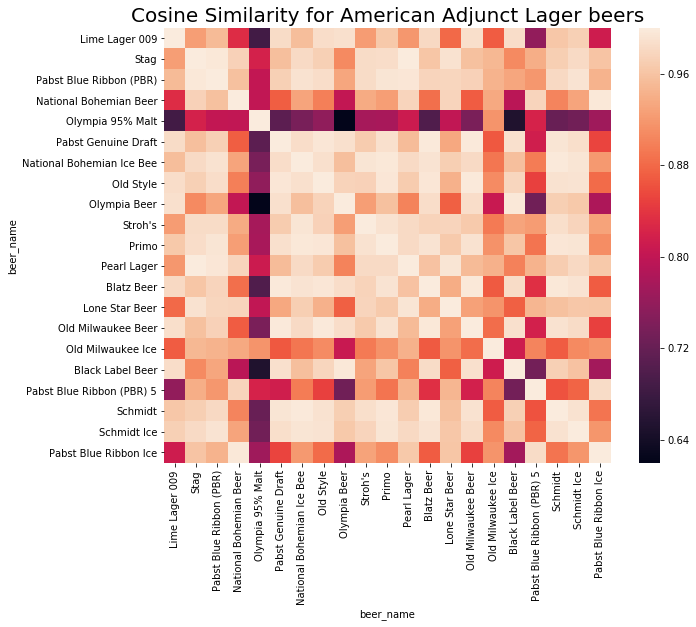

In [7]:
scores = results[["overall", "appearance","aroma","taste","beer_name","palate","style"]]

for style in set(scores["style"].values):
    style_scores = scores[scores['style'] == style]
    style_scores.set_index('beer_name', inplace=True)
    if style_scores.drop(columns="style").shape[0] >= 2 and style_scores.shape != (2, 5):
        style_scores.drop(columns="style", inplace=True)
        cubed_style_scores = np.power(style_scores, 6)
        sim_matrix = cosine_similarity(cubed_style_scores, cubed_style_scores)
        # I don't want to print anything that is incredibly similar
        # especially when I have made transformations
        # to make beers stand out
        if (sim_matrix.max() - sim_matrix.min() > .3):
            display(HTML(f"<h1>{style} Beers scores and Cosine Simularity Heatmaps</h1>"))
            display(HTML("<br>"))
            style_scores.rename(index={beer: beer[:25] for beer in style_scores.index}, inplace=True)
            sorted_style_scores = style_scores.sort_values(by="overall", ascending=False)
            display(sorted_style_scores)
            beer_sim = pd.DataFrame(sim_matrix, columns=sorted_style_scores.index, index=sorted_style_scores.index)        
            plt.figure(figsize=(10,8))
            sns.heatmap(beer_sim)
            plt.title(f"Cosine Similarity for {style} beers", fontdict={"fontsize":20})
            [display(HTML("<br>")) for _ in range(2)]
            plt.show()
            display(HTML("<hr style='color:black!important;height:2px'/>"))
            [display(HTML("<br>")) for _ in range(2)]

# Beer Recommendations

I will now recommend beers based on user preferences and location.

In [8]:
# I want to get the averages scores 
# and styles
# of beer reviews for all of the beers
# within a 10 mile radius of GA
# that are rated better than 3

within_x_miles_of_sm = """
SELECT 
styles.name as style,
breweries.name,
beers.name as beer_name,
AVG(reviews.review_overall) as overall,
AVG(reviews.review_appearance) as appearance,
AVG(reviews.review_aroma) as aroma,
AVG(reviews.review_taste) as taste,
AVG(reviews.review_palate) as palate
FROM
reviews, styles, beers, breweries
WHERE
reviews.beer_id = beers.id
AND review_overall > 3
AND styles.id = beers.id
AND ST_DWithin(
    ST_GeomFromText('POINT(34.01080683333333 -118.4922238333333)', 4326),
    ST_GeomFromText(ST_AsText(breweries.position),4326), 10/57.884
)
GROUP BY ST_DWithin(
    ST_GeomFromText('POINT(34.01080683333333 -118.4922238333333)', 4326),
    ST_GeomFromText(ST_AsText(breweries.position),4326), 10/57.884
), breweries.name, styles.name, 
beers.name, reviews.review_overall,
reviews.review_appearance,
reviews.review_aroma,
reviews.review_taste,
reviews.review_palate;
"""

local_results = pd.read_sql(within_x_miles_of_sm, con=engine)

I get back 25534 Reviews

In [9]:
local_results.shape

(25534, 8)

In [10]:
local_results.head()

,style,name,beer_name,overall,appearance,aroma,taste,palate
0,American Amber / Red Ale,6th & La Brea,McNeill's Extra Special Bitter,3.5,2.5,4.0,4.0,3.5
1,American Amber / Red Ale,6th & La Brea,McNeill's Extra Special Bitter,3.5,3.0,2.0,4.0,3.0
2,American Amber / Red Ale,6th & La Brea,McNeill's Extra Special Bitter,3.5,3.5,3.5,3.5,3.5
3,American Amber / Red Ale,6th & La Brea,McNeill's Extra Special Bitter,3.5,3.5,3.5,4.0,4.0
4,American Amber / Red Ale,6th & La Brea,McNeill's Extra Special Bitter,3.5,3.5,4.0,3.5,3.0


In [11]:
local_results.tail()

,style,name,beer_name,overall,appearance,aroma,taste,palate
25529,Winter Warmer,Venice Duck Brewery,Brewer's Gold,4.5,4.0,3.5,4.0,4.5
25530,Winter Warmer,Venice Duck Brewery,Brewer's Gold,4.5,4.0,4.0,4.5,4.5
25531,Winter Warmer,Venice Duck Brewery,Brewer's Gold,4.5,4.5,4.5,4.5,4.0
25532,Winter Warmer,Venice Duck Brewery,Brewer's Gold,4.5,4.5,4.5,4.5,4.5
25533,Winter Warmer,Venice Duck Brewery,Brewer's Gold,5.0,4.0,4.0,4.0,4.0


In [12]:
local_results.isnull().sum()

style           0
name            0
beer_name       0
overall         0
appearance    765
aroma         765
taste         765
palate        765
dtype: int64

In [13]:
local_results.dropna(inplace=True)

I will now pick three beers that I enjoy and use this to investigate whether or not this recommendation system might work.

In [14]:
# pick 3 beers
# recommend nearby based on style
# and cosine simularity

my_three_beers_query = """
SELECT 
beers.name, styles.name as style,
AVG(reviews.review_overall) as overall,
AVG(reviews.review_appearance) as appearance,
AVG(reviews.review_aroma) as aroma,
AVG(reviews.review_taste) as taste,
AVG(reviews.review_palate) as palate,
COUNT(reviews.id)
FROM beers, reviews, styles 
WHERE beers.style_id = styles.id 
AND reviews.beer_id = beers.id 
AND (beers.name = 'Tart Of Darkness' 
OR beers.name = 'Old Rasputin'
OR beers.name = 'Heady Topper')
GROUP BY beers.name, styles.name;
"""
my_three_beers = pd.read_sql(sql(my_three_beers_query), con=engine)

In [15]:
my_three_beers

,name,style,overall,appearance,aroma,taste,palate,count
0,Heady Topper,New England IPA,4.626712,4.163228,4.660847,4.609259,4.405820,949
1,Old Rasputin,Russian Imperial Stout,4.174406,4.374197,4.198827,4.342304,4.232005,3112
2,Tart Of Darkness,American Wild Ale,4.126984,3.960317,4.095238,4.142857,3.968254,126


Now I will see what styles from the local breweries are available to match up against.

In [16]:
local_styles = local_results[local_results["style"].isin(set(my_three_beers["style"]))]['style'].unique()
local_styles

array(['American Wild Ale', 'New England IPA', 'Russian Imperial Stout'],
      dtype=object)

In [17]:
local_matches = local_results[local_results["style"].isin(local_styles)] 
local_matches.shape

(340, 8)

In [18]:
local_matches.head()

,style,name,beer_name,overall,appearance,aroma,taste,palate
232,American Wild Ale,6th & La Brea,Oh My Gourd,3.75,3.50,3.50,3.50,3.5
233,American Wild Ale,6th & La Brea,Oh My Gourd,4.00,3.75,4.00,4.00,4.0
234,American Wild Ale,6th & La Brea,Oh My Gourd,4.25,3.75,4.25,4.25,4.0
1303,New England IPA,6th & La Brea,Honey Badger,3.25,3.00,3.25,3.25,3.0
1304,New England IPA,6th & La Brea,Honey Badger,3.50,3.50,3.50,3.50,3.5


In [19]:
local_matches.tail()

,style,name,beer_name,overall,appearance,aroma,taste,palate
25357,Russian Imperial Stout,Venice Duck Brewery,Brown-Eyed Girl,4.0,3.50,3.50,4.0,4.0
25358,Russian Imperial Stout,Venice Duck Brewery,Brown-Eyed Girl,4.0,3.50,3.50,4.0,4.5
25359,Russian Imperial Stout,Venice Duck Brewery,Brown-Eyed Girl,4.0,3.75,3.75,4.0,4.0
25360,Russian Imperial Stout,Venice Duck Brewery,Brown-Eyed Girl,4.0,4.00,4.00,4.0,4.0
25361,Russian Imperial Stout,Venice Duck Brewery,Brown-Eyed Girl,4.5,4.00,4.00,4.5,4.0


In [20]:
local_matches.dropna(inplace=True)

c:\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
local_matches.beer_name.unique()

array(['Oh My Gourd', 'Honey Badger', 'Brown-Eyed Girl'], dtype=object)

In [22]:
local_matches.shape

(340, 8)

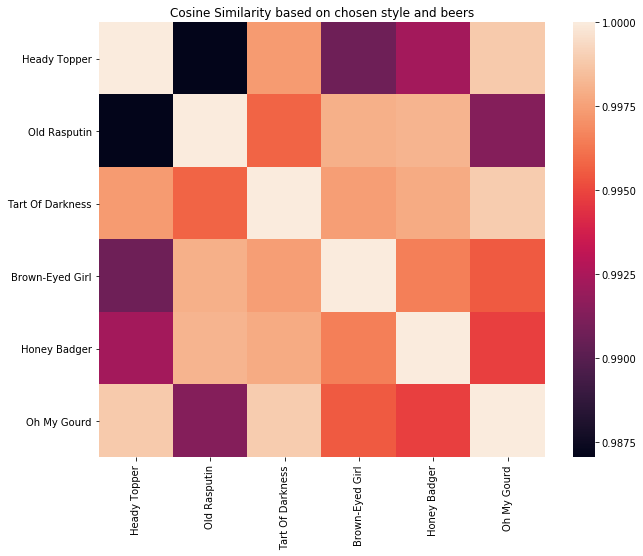

In [23]:
beer_sim_mat = pd.concat([
    my_three_beers.groupby(["name"])[["overall", "appearance","aroma","taste","palate"]].mean(),
    local_matches.groupby(["beer_name"])[["overall", "appearance","aroma","taste","palate"]].mean()
])

beer_sim_mat_cubed = np.power(beer_sim_mat, 3)
sim_matrix = cosine_similarity(beer_sim_mat_cubed, beer_sim_mat_cubed)

beer_sim = pd.DataFrame(sim_matrix, columns=beer_sim_mat.index, index=beer_sim_mat.index)        
plt.figure(figsize=(10,8))
sns.heatmap(beer_sim)
plt.title(f"Cosine Similarity based on chosen style and beers")
[print() for i in range(5)]
plt.show()

In [24]:
pd.DataFrame(sim_matrix, index=beer_sim.index, columns=beer_sim.index)

,Heady Topper,Old Rasputin,Tart Of Darkness,Brown-Eyed Girl,Honey Badger,Oh My Gourd
Heady Topper,1.000000,0.987038,0.997316,0.990721,0.992297,0.998838
Old Rasputin,0.987038,1.000000,0.995766,0.997984,0.998132,0.991348
Tart Of Darkness,0.997316,0.995766,1.000000,0.997468,0.997859,0.998892
Brown-Eyed Girl,0.990721,0.997984,0.997468,1.000000,0.996513,0.995511
Honey Badger,0.992297,0.998132,0.997859,0.996513,1.000000,0.994811
Oh My Gourd,0.998838,0.991348,0.998892,0.995511,0.994811,1.000000
